### КУРСОВОЙ ПРОЕКТ "РЕКОМЕНДАТЕЛЬНЫЕ СИСТЕМЫ".

### Загрузка библиотек:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

import pickle

### Параметры отображения:

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import sys
np.set_printoptions(threshold=sys.maxsize)

import warnings
warnings.filterwarnings('ignore')

### Загрузка данных для обучения:

In [3]:
data_train = pd.read_csv('C:/Study/Рекомендательные системы/2/webinar_2/retail_train.csv')

### Загрузка данных для рекомендаций:

In [4]:
data_pred = pd.read_csv('C:/Study/Рекомендательные системы/kurs/retail_test.csv')

### Обзор данных:

In [5]:
data_pred.head()

user_id  item_id
0     1340   912987
1      588  1024426
2     2070   995242
3     1602   827939
4     1602   927712

In [6]:
data_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79282 entries, 0 to 79281
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  79282 non-null  int64
 1   item_id  79282 non-null  int64
dtypes: int64(2)
memory usage: 1.2 MB


In [7]:
data_train.sample(5)

user_id    basket_id  day  item_id  quantity  sales_value  store_id  \
212526       236  28345122328  114  1004480         1        0.500       401   
2270176     2252  41259580813  634  1006829         1        3.990       323   
865888      2047  31198209175  284  1043663         1        2.490       310   
390533      2347  29115062588  161  1027569         1        1.990       438   
1039374      324  31833951989  327  5570383         1        4.000       367   

         retail_disc  trans_time  week_no  coupon_disc  coupon_match_disc  
212526        -0.290        1705       17        0.000              0.000  
2270176        0.000        1030       91        0.000              0.000  
865888         0.000        1801       41        0.000              0.000  
390533         0.000        1919       24        0.000              0.000  
1039374       -0.690        2016       47        0.000              0.000

In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2396804 entries, 0 to 2396803
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            int64  
 1   basket_id          int64  
 2   day                int64  
 3   item_id            int64  
 4   quantity           int64  
 5   sales_value        float64
 6   store_id           int64  
 7   retail_disc        float64
 8   trans_time         int64  
 9   week_no            int64  
 10  coupon_disc        float64
 11  coupon_match_disc  float64
dtypes: float64(4), int64(8)
memory usage: 219.4 MB


In [9]:
data_train.describe()

user_id       basket_id         day      item_id    quantity  \
count 2396804.000     2396804.000 2396804.000  2396804.000 2396804.000   
mean     1271.904 33366432676.480     363.977  2827247.092     100.376   
std       726.564  4284798175.928     175.939  3732797.659    1152.379   
min         1.000 26984851472.000       1.000    25671.000       0.000   
25%       655.000 30087143433.000     216.000   916993.000       1.000   
50%      1271.000 32419978306.000     366.000  1027569.000       1.000   
75%      1914.000 35145801967.000     515.000  1132178.000       1.000   
max      2500.000 41656790510.000     663.000 18024556.000   89638.000   

       sales_value    store_id  retail_disc  trans_time     week_no  \
count  2396804.000 2396804.000  2396804.000 2396804.000 2396804.000   
mean         3.101    3048.227       -0.540    1561.714      52.682   
std          4.210    8785.542        1.246     401.569      25.133   
min          0.000       1.000     -130.020       0.000       1.000   
25%          1.290     330.000       -0.690    1307.000      32.000   
50%          2.000     370.000       -0.020    1614.000      53.000   
75%          3.490     422.000        0.000    1844.000      74.000   
max        840.000   34280.000        3.990    2359.000      95.000   

       coupon_disc  coupon_match_disc  
count  2396804.000        2396804.000  
mean        -0.016             -0.003  
std          0.217              0.040  
min        -55.930             -7.700  
25%          0.000              0.000  
50%          0.000              0.000  
75%          0.000              0.000  
max          0.000              0.000

### Поиск Nan значений:

In [10]:
data_pred.isna().sum()

user_id    0
item_id    0
dtype: int64

In [11]:
data_train.isna().sum()

user_id              0
basket_id            0
day                  0
item_id              0
quantity             0
sales_value          0
store_id             0
retail_disc          0
trans_time           0
week_no              0
coupon_disc          0
coupon_match_disc    0
dtype: int64

#### Отсутствующих значений в обоих датасетах не выявлено.

### Поиск отрицательных значений:

In [12]:
(data_train['retail_disc'] < 0).sum()

1205323

In [13]:
(data_train['coupon_disc'] < 0).sum()

33429

In [14]:
(data_train['coupon_match_disc'] < 0).sum()

15965

#### Выявлены отрицательные значения по скидкам.

#### Следуя логике здравого смысла, скидки не могут быть отрицательными, в то же время признак 'retail_disc' показывает отрицательные значения в половине записей, что может указывать на наличие не скидки, а наценки. Наценок по купонам существовать не может, поэтому принимается версия об ошибочной записи с отрицательным знаком. Также на это указывает относительно небольшое число таких значений.

#### Домножаем отрицательные значения на -1:

In [15]:
data_train.loc[data_train['coupon_disc'] < 0, 'coupon_disc'] *=-1

In [16]:
data_train.loc[data_train['coupon_match_disc'] < 0, 'coupon_match_disc'] *=-1

### Анализ распределения признаков:

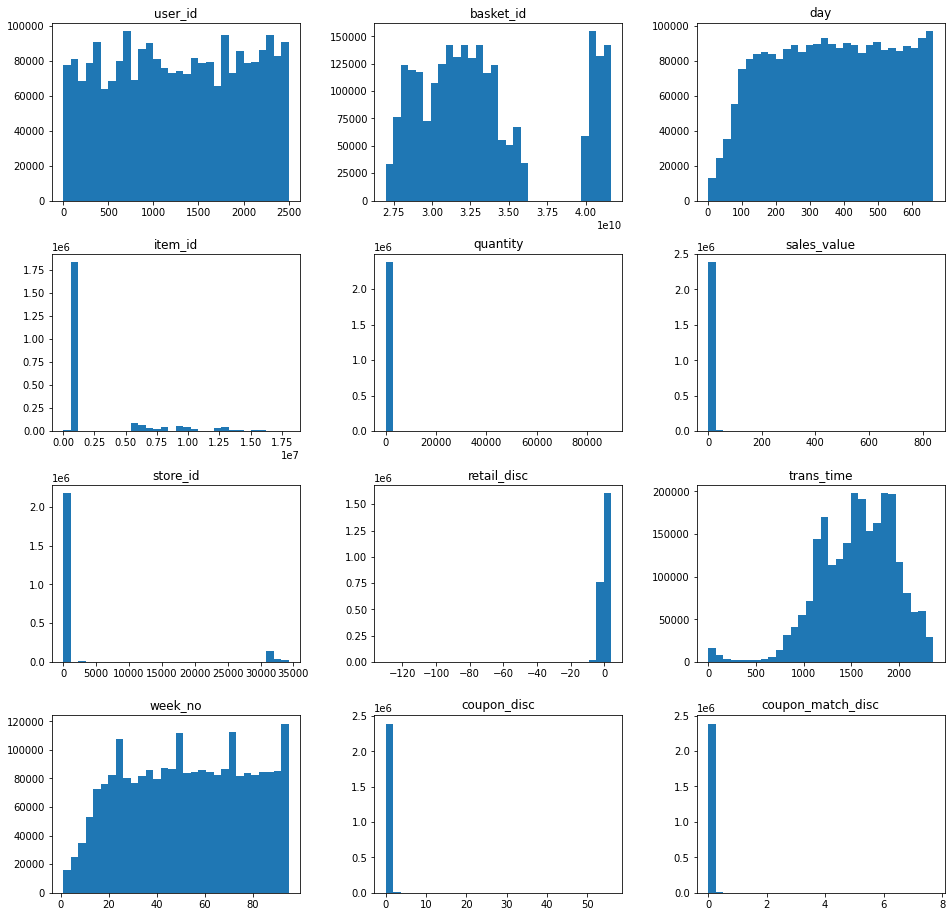

In [17]:
data_train.hist(figsize=(16,16), bins=30, grid=False);

#### В целях уменьшения сложности и времени вычислений принято решение избавиться от неинформативных признаков:

In [18]:
data_train.drop('store_id', axis=1, inplace=True)
data_train.drop('basket_id', axis=1, inplace=True)
data_train.drop('day', axis=1, inplace=True)
data_train.drop('week_no', axis=1, inplace=True)

In [19]:
data_train.head(2)

user_id  item_id  quantity  sales_value  retail_disc  trans_time  \
0     2375  1004906         1        1.390       -0.600        1631   
1     2375  1033142         1        0.820        0.000        1631   

   coupon_disc  coupon_match_disc  
0        0.000              0.000  
1        0.000              0.000

#### Группировка товаров по покупателям:

In [20]:
data_pred = data_pred.groupby('user_id')['item_id'].unique().reset_index()
data_pred.columns=['user_id', 'actual']
data_pred.head(2)

user_id  \
0        1   
1        2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                actual  
0                                                                                                                                                                                                              [880007, 883616, 931136, 938004, 940947, 947267, 952924, 958046, 959219, 961554, 962568, 965766, 976335, 979707, 986947, 990656, 991024, 1004906, 1005186, 1037507, 1037863, 1045285, 1046816, 1049998, 1062002, 1075074, 1087268, 1112333, 1131321, 1132231, 5582712, 9527558, 12330539, 13877012, 15800711, 15830875]  
1  [820165, 820291, 826784, 826835, 829009, 857849, 866211, 866950, 870608, 874058, 879769, 885023, 899624, 903674, 922663, 940947, 947798, 951412, 951590, 956440, 960791, 976065, 986293, 988044, 989101, 989935, 990656, 1003188, 1003421, 1006474, 1013321, 1026118, 1037965, 1044759, 1049788, 1053690, 1079659, 1096317, 1108168, 1116821, 1131974, 1133018, 1135476, 1139142, 5568228, 7167853, 7410217, 8019273, 12263464, 12263604, 12302069, 13133971, 13417250, 14110837, 15596879, 15687014, 15926927, 15973010, 17249704]

#### Определим 5000 популярных товаров:

In [21]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

# Заведем фиктивный item_id (если юзер покупал товары не из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

In [22]:
pd.set_option('display.max_rows', 5)

### Создание матрицы user-item. Почему-то код из урока выдает неправильную индексацию. Отсутствует элемент под индексом 2325. Не смог разобраться почему. В результате модель выдает ошибку, т.к. не может найти этот элемент.

In [23]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix.iloc[2322:2327]

item_id  202291    397896    420647    480014    545926    707683    731106    \
user_id                                                                         
2323            0         0         0         0         0         0         0   
2324            0         0         0         0         0         0         0   
2326            0         0         0         0         0         0         0   
2327            0         0         0         0         0         0         0   
2328            0         0         0         0         0         0         0   

item_id  818980    819063    819227    819255    819304    819308    819330    \
user_id                                                                         
2323            0         0         0         0         0         0         0   
2324            0         0         8         0         0         0         0   
2326            1         0         0         0         0         0         0   
2327            0         0         0         0         0         0         0   
2328            0         0         0         0         0         0         0   

item_id  819518    819594    819643    819765    819840    819845    819927    \
user_id                                                                         
2323            0         0         0         0         0         0         0   
2324            0         0         0         0         0         0         0   
2326            0         0         0         0         0         0         1   
2327            0         0         0         0         0         0         0   
2328            0         2         0         0         0         0         0   

item_id  819978    820082    820122    820165    820291    820301    820321    \
user_id                                                                         
2323            0         0         0         0         0         0         0   
2324            0         0         0         1         0         0         0   
2326            0         0         0         0         0         0         0   
2327            0         0         0         0         0         0         0   
2328            0         0         0         6         0         0         0   

item_id  820347    820361    820486    820518    820560    820895    821025    \
user_id                                                                         
2323            0         0         0         0         0         0         0   
2324            0         0         0         0         0         0         0   
2326            0         0         0         0         0         0         0   
2327            0         0         0         0         0         0         0   
2328            0         0         0         0         0         0         0   

item_id  821083    821200    821209    821219    821344    821464    821556    \
user_id                                                                         
2323            0         0         0         0         0         0         0   
2324            0         0         0         0         0         0         0   
2326            0         0         0         0         0         0         0   
2327            0         0         0         0         0         0         0   
2328            1         0         0         0         0         0         0   

item_id  821562    821695    821730    821735    821787    821867    821976    \
user_id                                                                         
2323            0         0         0         0         0         0         0   
2324            0         0         0         0         0         0         0   
2326            0         0         0         0         0         0         0   
2327            0         0         0         0         0         0         1   
2328            0         0         0         0         0         0         0   

item_id  822049    82207

#### Проводим реиндексацию и видим, что индекс последнего элемента уменьшился на -1. Но порядок индексов теперь не нарушен.

In [24]:
user_item_matrix = user_item_matrix.reindex(range(1,2500),method='ffill')
user_item_matrix

item_id  202291    397896    420647    480014    545926    707683    731106    \
user_id                                                                         
1               0         0         0         0         0         0         0   
2               0         0         0         0         0         0         0   
...           ...       ...       ...       ...       ...       ...       ...   
2498            2         0         0         0         0         0         0   
2499            0         0         0         0         0         0         0   

item_id  818980    819063    819227    819255    819304    819308    819330    \
user_id                                                                         
1               0         0         0         0         0         0         0   
2               0         0         0         0         0         0         0   
...           ...       ...       ...       ...       ...       ...       ...   
2498            0         0         0         0         0         0         0   
2499            0         0         0         0         0         0         0   

item_id  819518    819594    819643    819765    819840    819845    819927    \
user_id                                                                         
1               0         0         0         0         0         0         0   
2               0         0         0         0         0         0         0   
...           ...       ...       ...       ...       ...       ...       ...   
2498            0         0         0         0         0         0         1   
2499            0         0         0         0         0         0         0   

item_id  819978    820082    820122    820165    820291    820301    820321    \
user_id                                                                         
1               0         0         0         2         0         0         0   
2               0         0         0         0         0         1         0   
...           ...       ...       ...       ...       ...       ...       ...   
2498            0         0         0         0         0         0         0   
2499            0         0         2         0         0         0         1   

item_id  820347    820361    820486    820518    820560    820895    821025    \
user_id                                                                         
1               0         0         0         0         0         0         0   
2               0         0         0         0         0         0         0   
...           ...       ...       ...       ...       ...       ...       ...   
2498            0         0         0         0         1         0         0   
2499            0         0         0         0         0         0         0   

item_id  821083    821200    821209    821219    821344    821464    821556    \
user_id                                                                         
1               0         0         0         0         0         0         0   
2               1         0         0         0         0         0         0   
...           ...       ...       ...       ...       ...       ...       ...   
2498            1         0         0         0         0         0         0   
2499            0         0         0         0         2         0         1   

item_id  821562    821695    821730    821735    821787    821867    821976    \
user_id                                                                         
1               0         0         0         0         0         1         0   
2               0         0         0         0         0         0         0   
...           ...       ...       ...       ...       ...       ...       ...   
2498            0         0         0         0         0         0         0   
2499            0         0         0         2         0         1         0   

item_id  822049    82207

#### Приходится два раза добавлять фиктивную запись, потому что метод append в первый раз создает элемент под индексом 0, котрый отсутствует в изначально созданной выше pivot_table.

In [25]:
user_item_matrix = user_item_matrix.append(user_item_matrix.iloc[2498],ignore_index=True)
user_item_matrix = user_item_matrix.append(user_item_matrix.iloc[2499],ignore_index=True)
user_item_matrix

item_id  202291    397896    420647    480014    545926    707683    731106    \
0               0         0         0         0         0         0         0   
1               0         0         0         0         0         0         0   
...           ...       ...       ...       ...       ...       ...       ...   
2499            0         0         0         0         0         0         0   
2500            0         0         0         0         0         0         0   

item_id  818980    819063    819227    819255    819304    819308    819330    \
0               0         0         0         0         0         0         0   
1               0         0         0         0         0         0         0   
...           ...       ...       ...       ...       ...       ...       ...   
2499            0         0         0         0         0         0         0   
2500            0         0         0         0         0         0         0   

item_id  819518    819594    819643    819765    819840    819845    819927    \
0               0         0         0         0         0         0         0   
1               0         0         0         0         0         0         0   
...           ...       ...       ...       ...       ...       ...       ...   
2499            0         0         0         0         0         0         0   
2500            0         0         0         0         0         0         0   

item_id  819978    820082    820122    820165    820291    820301    820321    \
0               0         0         0         2         0         0         0   
1               0         0         0         0         0         1         0   
...           ...       ...       ...       ...       ...       ...       ...   
2499            0         0         2         0         0         0         1   
2500            0         0         2         0         0         0         1   

item_id  820347    820361    820486    820518    820560    820895    821025    \
0               0         0         0         0         0         0         0   
1               0         0         0         0         0         0         0   
...           ...       ...       ...       ...       ...       ...       ...   
2499            0         0         0         0         0         0         0   
2500            0         0         0         0         0         0         0   

item_id  821083    821200    821209    821219    821344    821464    821556    \
0               0         0         0         0         0         0         0   
1               1         0         0         0         0         0         0   
...           ...       ...       ...       ...       ...       ...       ...   
2499            0         0         0         0         2         0         1   
2500            0         0         0         0         2         0         1   

item_id  821562    821695    821730    821735    821787    821867    821976    \
0               0         0         0         0         0         1         0   
1               0         0         0         0         0         0         0   
...           ...       ...       ...       ...       ...       ...       ...   
2499            0         0         0         2         0         1         0   
2500            0         0         0         2         0         1         0   

item_id  822049    822073    822140    822178    822225    822241    822339    \
0               0         0         0         0         0         0         0   
1               0         0         0         0         0         1         0   
...           ...       ...       ...       ...       ...       ...       ...   
2499            0         0         0         0         0         1         0   
2500            0         0         0         0         0         1         0   

item_id  822346    822407    822517    822524    822646    822677    822739    \
0               0      

#### Удаляем лишнюю запись под индексом 0.

#### Теперь матрица проиндексирована от 1 до 2500, как изначально и задумывалось. Только после этих манипуляций модель начинает работать.

In [26]:
user_item_matrix.drop(index=user_item_matrix.index [0], axis= 0 , inplace= True )
user_item_matrix

item_id  202291    397896    420647    480014    545926    707683    731106    \
1               0         0         0         0         0         0         0   
2               0         0         0         0         0         0         0   
...           ...       ...       ...       ...       ...       ...       ...   
2499            0         0         0         0         0         0         0   
2500            0         0         0         0         0         0         0   

item_id  818980    819063    819227    819255    819304    819308    819330    \
1               0         0         0         0         0         0         0   
2               0         0         0         1         0         0         0   
...           ...       ...       ...       ...       ...       ...       ...   
2499            0         0         0         0         0         0         0   
2500            0         0         0         0         0         0         0   

item_id  819518    819594    819643    819765    819840    819845    819927    \
1               0         0         0         0         0         0         0   
2               0         0         0         0         0         0         0   
...           ...       ...       ...       ...       ...       ...       ...   
2499            0         0         0         0         0         0         0   
2500            0         0         0         0         0         0         0   

item_id  819978    820082    820122    820165    820291    820301    820321    \
1               0         0         0         0         0         1         0   
2               0         0         0         0         0         0         0   
...           ...       ...       ...       ...       ...       ...       ...   
2499            0         0         2         0         0         0         1   
2500            0         0         2         0         0         0         1   

item_id  820347    820361    820486    820518    820560    820895    821025    \
1               0         0         0         0         0         0         0   
2               0         0         0         0         0         0         0   
...           ...       ...       ...       ...       ...       ...       ...   
2499            0         0         0         0         0         0         0   
2500            0         0         0         0         0         0         0   

item_id  821083    821200    821209    821219    821344    821464    821556    \
1               1         0         0         0         0         0         0   
2               0         0         0         0         0         0         0   
...           ...       ...       ...       ...       ...       ...       ...   
2499            0         0         0         0         2         0         1   
2500            0         0         0         0         2         0         1   

item_id  821562    821695    821730    821735    821787    821867    821976    \
1               0         0         0         0         0         0         0   
2               0         0         0         0         0         0         0   
...           ...       ...       ...       ...       ...       ...       ...   
2499            0         0         0         2         0         1         0   
2500            0         0         0         2         0         1         0   

item_id  822049    822073    822140    822178    822225    822241    822339    \
1               0         0         0         0         0         1         0   
2               0         0         0         0         0         0         0   
...           ...       ...       ...       ...       ...       ...       ...   
2499            0         0         0         0         0         1         0   
2500            0         0         0         0         0         1         0   

item_id  822346    822407    822517    822524    822646    822677    822739    \
1               0      

#### Создание матрицы для implicit:

In [27]:
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit
sparse_user_item = csr_matrix(user_item_matrix).tocsr() # переведем в формат saprse matrix

#### Создание матриц перевода индексов:

In [28]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

### Создание и обучение модели:

#### Была выбрана ALS модель с TfIdf взвешиванием и подобранными гиперпараметрами.

In [29]:
tfidf_user_item_matrix = tfidf_weight(user_item_matrix).tocsr()

In [30]:
model = AlternatingLeastSquares(factors=50, 
                                regularization=0.01,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4,
                                random_state=42)

model.fit(tfidf_user_item_matrix, show_progress=True)

  0%|          | 0/15 [00:00<?, ?it/s]

### Функции рекомендаций и метрик:

In [31]:
def get_recommendations(user, model, sparse_user_item, N=5):
    res = [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item[userid_to_id[user]],
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)[0]]
    return res

In [32]:
def precision_at_k(recommended_list, bought_list, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    bought_list = bought_list
    recommended_list = recommended_list[:k]
    flags = np.isin(recommended_list, bought_list)
    precision = flags.sum() / len(recommended_list)
    return precision

In [33]:
def ap_at_k(recommended_list, bought_list, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    flags = np.isin(recommended_list,bought_list)
    if sum(flags) == 0:
        return 0
    sum_ = 0
    for i in range(k):
        if flags[i]:
            p_k = precision_at_k(recommended_list, bought_list, k=i+1)
            sum_ += p_k    
    result = sum_ / k
    return result

### Получение результатов:

In [34]:
data_pred['als_tfidf'] = data_pred['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=10))
data_pred.head(2)

user_id  \
0        1   
1        2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                actual  \
0                                                                                                                                                                                                              [880007, 883616, 931136, 938004, 940947, 947267, 952924, 958046, 959219, 961554, 962568, 965766, 976335, 979707, 986947, 990656, 991024, 1004906, 1005186, 1037507, 1037863, 1045285, 1046816, 1049998, 1062002, 1075074, 1087268, 1112333, 1131321, 1132231, 5582712, 9527558, 12330539, 13877012, 15800711, 15830875]   
1  [820165, 820291, 826784, 826835, 829009, 857849, 866211, 866950, 870608, 874058, 879769, 885023, 899624, 903674, 922663, 940947, 947798, 951412, 951590, 956440, 960791, 976065, 986293, 988044, 989101, 989935, 990656, 1003188, 1003421, 1006474, 1013321, 1026118, 1037965, 1044759, 1049788, 1053690, 1079659, 1096317, 1108168, 1116821, 1131974, 1133018, 1135476, 1139142, 5568228, 7167853, 7410217, 8019273, 12263464, 12263604, 12302069, 13133971, 13417250, 14110837, 15596879, 15687014, 15926927, 15973010, 17249704]   

                                                                                  als_tfidf  
0  [995242, 5569230, 1133018, 1106523, 8090521, 1082185, 1029743, 951590, 1053690, 1075368]  
1   [951590, 1106523, 8090521, 1092026, 1029743, 1133018, 5569230, 1053690, 883404, 844165]

In [35]:
data_pred.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()

0.11586206896551725

In [36]:
data_pred.apply(lambda row: ap_at_k(row['als_tfidf'], row['actual']), axis=1).mean()

0.07436427939876217

#### Результаты получились неудовлетварительными вероятно из-за манипуляций с матрицей user_item_matrix.

### Запись в файл:

In [37]:
test_id = data_pred['user_id']
pred_df = pd.DataFrame()
pred_df["Id"] = test_id
pred_df["Recs"] = data_pred['als_tfidf']
pred_df.to_csv("C:\Study\Рекомендательные системы\kurs\predictions_GB.csv", index=False)

### Дополнительно:

#### Самостоятельно написанная функция (не из учебных блокнотов) рекомендации рандомных, взвешенных по популярности, товаров из списка в 100 позиций:

In [42]:
def pop_w_recs(n):
    popular = data_train.groupby('item_id')['quantity'].sum().reset_index()
    popular.sort_values('quantity', ascending=False, inplace=True)
    popular = popular.head(100)
    popular.head()
    
    result = []
    for i in range(len(data_pred['actual'])):
        result.append(popular['item_id'].sample(n).tolist())
    
    return result

In [43]:
data_pred['pop_w_recs'] = pop_w_recs(20)
data_pred.head(2)

user_id  \
0        1   
1        2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                actual  \
0                                                                                                                                                                                                              [880007, 883616, 931136, 938004, 940947, 947267, 952924, 958046, 959219, 961554, 962568, 965766, 976335, 979707, 986947, 990656, 991024, 1004906, 1005186, 1037507, 1037863, 1045285, 1046816, 1049998, 1062002, 1075074, 1087268, 1112333, 1131321, 1132231, 5582712, 9527558, 12330539, 13877012, 15800711, 15830875]   
1  [820165, 820291, 826784, 826835, 829009, 857849, 866211, 866950, 870608, 874058, 879769, 885023, 899624, 903674, 922663, 940947, 947798, 951412, 951590, 956440, 960791, 976065, 986293, 988044, 989101, 989935, 990656, 1003188, 1003421, 1006474, 1013321, 1026118, 1037965, 1044759, 1049788, 1053690, 1079659, 1096317, 1108168, 1116821, 1131974, 1133018, 1135476, 1139142, 5568228, 7167853, 7410217, 8019273, 12263464, 12263604, 12302069, 13133971, 13417250, 14110837, 15596879, 15687014, 15926927, 15973010, 17249704]   

                                                                                  als_tfidf  \
0  [995242, 5569230, 1133018, 1106523, 8090521, 1082185, 1029743, 951590, 1053690, 1075368]   
1   [951590, 1106523, 8090521, 1092026, 1029743, 1133018, 5569230, 1053690, 883404, 844165]   

                                                                                                                                                                     pop_w_recs  
0    [1127831, 962229, 8090521, 878996, 1070820, 1096036, 914190, 908531, 1005186, 910032, 1013321, 854852, 397896, 1058997, 833715, 1022003, 834484, 6534178, 480014, 1053690]  
1  [6410464, 2848087, 1096036, 5703832, 929668, 1029743, 5569230, 995242, 986912, 938700, 883404, 826249, 1013321, 8090521, 397896, 1153346, 5747233, 1070820, 1071939, 927191]

In [44]:
data_pred.apply(lambda row: precision_at_k(row['pop_w_recs'], row['actual']), axis=1).mean()

0.04381962864721485

In [45]:
data_pred.apply(lambda row: ap_at_k(row['pop_w_recs'], row['actual']), axis=1).mean()

0.023418213969938106

### Результаты тоже не слишком хороши в силу случайности выбора для рекомендации. В файл записывать не стал, чтобы никого не путать.